In [ ]:
!pip install pykrx
!pip install sklearn
!pip install tensorflow

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch, gc
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from pykrx import stock
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.layers import Dense, LSTM
from keras.models import Sequential, load_model


```

```
# 1. 데이터 다운로드 및 전처리
```


```



## 2) 데이터 불러오기 (5년 치, 10년 치, 50년 치)

### (1) 8개 종목 선택

KB금융	105560 신한지주	055550 하나금융지주	086790 메리츠금융지주	138040 기업은행	024110 미래에셋증권	006800 NH투자증권	005940 삼성증권	016360

In [6]:
# Make code dictionary.
finance_code_dict = dict()
finance_code_list = "KB금융	105560 신한지주	055550 하나금융지주	086790 메리츠금융지주	138040 기업은행	024110 미래에셋증권	006800 NH투자증권	005940 삼성증권	016360".split()
for i in range(8):
  finance_code_dict[finance_code_list[2*i]] = finance_code_list[2*i + 1]

In [7]:
print(finance_code_dict)

{'KB금융': '105560', '신한지주': '055550', '하나금융지주': '086790', '메리츠금융지주': '138040', '기업은행': '024110', '미래에셋증권': '006800', 'NH투자증권': '005940', '삼성증권': '016360'}


{'KB금융': '105560', '신한지주': '055550', '하나금융지주': '086790', '메리츠금융지주': '138040', '기업은행': '024110', '미래에셋증권': '006800', 'NH투자증권': '005940', '삼성증권': '016360'}


### (2) 데이터 가져오기 함수 정의 (5y, 10y)

In [8]:
def get_5y_10y(ticker_name):
  ticker_code = finance_code_dict[ticker_name]
  return stock.get_market_ohlcv("20180101", "20221231", ticker_code), stock.get_market_ohlcv("20130101", "20221231", ticker_code)

### (3) 데이터 그리기 함수 정의

In [9]:
import matplotlib
import matplotlib.pyplot as plt

def draw_graph_10y(ticker_name):

  _, df = get_5y_10y(ticker_name)

  # 1 line, 3 graphs

  # graph 1
  plt.subplot(3, 1, 1)
  series = df['종가']
  plt.title(f"{ticker_name} time series")
  plt.spring()
  plt.plot(series)

  # graph 2
  plt.subplot(3, 1, 2)
  plt.title(f"{ticker_name} difference, time series")
  series_diff = series - series.shift(1)
  plt.plot(series_diff)

  # graph 3
  plt.subplot(3, 1, 3)
  plt.title(f"{ticker_name} difference, histogram")
  plt.hist(series_diff)

  plt.tight_layout()

  plt.show()

### (4) train_data, test_data 얻는 함수

rsi 계산 함수

In [11]:
# RSI 계산 함수
def calculate_rsi(data, period=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [12]:
# 데이터 기간 설정하는 부분

start_date_train = "20130101"
end_date_train = "20201231"
start_date_test = "20200101"
end_date_test = "20230630"

In [13]:
def get_10y_data(ticker_name):
  ticker_code = finance_code_dict[ticker_name]
  selected_columns = ['종가','거래량','RSI']  # 포함하려는 열 이름 리스트
  train_df = stock.get_market_ohlcv(start_date_train, end_date_train, ticker_code)
  test_df = stock.get_market_ohlcv(start_date_test, end_date_test, ticker_code)
  train_df['RSI'] = calculate_rsi(train_df['종가'])
  test_df['RSI'] = calculate_rsi(test_df['종가'])

  train_df = train_df.astype('float32')
  test_df = test_df.astype('float32')

  return pd.DataFrame(train_df[selected_columns]), pd.DataFrame(test_df[selected_columns])

# 2.Dataset 윈도우

In [17]:

from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
  # data_stream     : input_window, output_window 크기에 따라 쪼개질 데이터
  # input_window    : 인풋 기간
  # output_window   : 아웃풋 기간
  # stride          :
    def __init__(self, data_stream, input_window, output_window, n_features=3, stride=5):
        # data_stream의 행 개수를 구한다.
        L = data_stream.shape[0]
        # stride에 따라 샘플 개수를 구한다.
        num_samples = (L - input_window - output_window) // stride + 1

        # [window 크기 * sample 개수] 크기의, 0으로 채워진 배열을 만든다.
        X = np.zeros([input_window, num_samples, n_features])
        Y = np.zeros([output_window, num_samples])

        # np.arange(num_samples): range(num_samples) 와 같음
        for i in np.arange(num_samples):
            # 1) X:   input_window 만큼 자르기 (stride * i ~)
            start_x = stride * i
            X[:,i] = data_stream[start_x:start_x + input_window]
            # 2) Y:   output_window 만큼 자르기 (stride * i + input_window ~)
            start_y = start_x + input_window
            Y[:,i] = data_stream[start_y:start_y + output_window]['종가']


        # shape       : [window 크기, sample 개수]
        X = X.reshape(X.shape[0], X.shape[1], n_features).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        X=X.astype('float32')
        Y=Y.astype('float32')
        self.x = X
        self.y = Y

        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len



# 3.Transformer 모델 정의

In [18]:
class TFModel(nn.Module):

# iw/ow:      input window, output window
# d_model:    인풋 개수
# nlayers:    인코더 부분의 인코더 개수
# nhead:      multihead attention 개수

    def __init__(self, iw: int, ow: int, d_model: int, nhead: int, nlayers: int, dropout=0.5, n_features=3):
        super(TFModel, self).__init__()

        # TransformerEncoderLayer 인스턴스 생성 ) 1개 인코더, 인풋 사이즈가 d_model이고 attention 개수는 nhead
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)

        # stacked 인코더, nlayers 만큼 쌓여있다.
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)

        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # 인풋 차원 변환. 1차원 -> d_model//2차워 -> d_model차원
        self.encoder = nn.Sequential(
            # nn.Linear(1, d_model//2),
            nn.Linear(n_features, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        # 차원 변환. d_model -> d_model//2 -> 1
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        # 차원 변환. iw -> ow
        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )

    def generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask


# 4.학습

- 입출력 윈도우 사이즈
- Learning Rate
- Model
  - layer
  - dropout
  - multihead attention 개수
- Cost Function
- Optimizer




In [ ]:
# @title *데이터 가져오기*

train_data, test_data = get_10y_data('KB금융')

# 추가하는 부분
N_FEATURES = 3
print(test_data)

In [45]:
end_row = 21 # 21일치 데이터를 삭제해 줌(RSI계산 이슈)

# 특정 범위의 행 삭제
train_data = train_data.drop(train_data.index[0:end_row])
test_data = test_data.drop(test_data.index[0:end_row])


## **정규화** **진행**

In [ ]:
from scipy.stats import zscore

selected_column = ['종가', '거래량','RSI']

# 선택한 열의 값들을 z-score 정규화
selected_column_values = train_data[selected_column]
z_scores = zscore(selected_column_values)
train_data[selected_column] = z_scores

selected_column_values = test_data[selected_column]
z_scores = zscore(selected_column_values)
test_data[selected_column] = z_scores

print(test_data)


In [128]:
#lstm 데이터 세팅
INPUT_WINDOW = 14
OUTPUT_WINDOW = 14

train_X = train_data.to_numpy()
test_X = test_data.to_numpy()

train_y = train_X[:,0]
test_y = test_X[:,0]

#트렌스포머 WINDOW사이즈를 고려하여 데이터를 맞춰준다.

cut_size = INPUT_WINDOW - 1
train_X=train_X[cut_size:,]
train_y=train_y[cut_size:,]
test_X=test_X[cut_size:,]
test_y=test_y[cut_size:,]


기술지표 계산시 발생하는 NAN데이터 삭제

# TF model

ir = 1e-04
batch size = 32

In [126]:
# @title Hyper-parameter
INPUT_WINDOW = 14
OUTPUT_WINDOW = 14

BATCH_SIZE= 32

train_dataset = windowDataset(train_data, input_window=INPUT_WINDOW, output_window=OUTPUT_WINDOW, stride=1, n_features=N_FEATURES)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)     # 64 = 2^6, 512 = 2^9
test_dataset = windowDataset(test_data, input_window=INPUT_WINDOW, output_window=OUTPUT_WINDOW, stride=1, n_features=N_FEATURES)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)     # 64 = 2^6, 512 = 2^9


if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

lr = 1e-4 # 학습률을 적당히 설정하는 게 중요함.

tf_model = TFModel(iw=INPUT_WINDOW, ow=OUTPUT_WINDOW, d_model=512, nhead=8, nlayers=4, dropout=0.1, n_features=N_FEATURES).to(device)
criterion = nn.MSELoss()                                            # MSEloss(): ow 각 요소들의 합
optimizer = torch.optim.Adam(tf_model.parameters(), lr=lr)

In [54]:
train_losses = []  # 각 에포크의 훈련 손실 값을 저장할 리스트


loss: 1.045054:   2%|▏         | 1/50 [00:01<00:59,  1.21s/it]

loss: 1.038659:   4%|▍         | 2/50 [00:02<00:53,  1.12s/it]

loss: 1.038999:   6%|▌         | 3/50 [00:03<00:51,  1.09s/it]

loss: 1.043782:   8%|▊         | 4/50 [00:04<00:49,  1.08s/it]

loss: 1.054413:  10%|█         | 5/50 [00:05<00:48,  1.07s/it]

loss: 1.065868:  12%|█▏        | 6/50 [00:06<00:46,  1.06s/it]

loss: 1.106360:  14%|█▍        | 7/50 [00:07<00:45,  1.07s/it]

loss: 1.082839:  16%|█▌        | 8/50 [00:08<00:44,  1.06s/it]

loss: 1.047741:  18%|█▊        | 9/50 [00:09<00:43,  1.06s/it]

loss: 1.042039:  20%|██        | 10/50 [00:10<00:42,  1.06s/it]

loss: 1.044171:  22%|██▏       | 11/50 [00:11<00:43,  1.12s/it]

loss: 1.041100:  22%|██▏       | 11/50 [00:13<00:46,  1.20s/it]


Early stopping due to no improvement for 10 epochs.


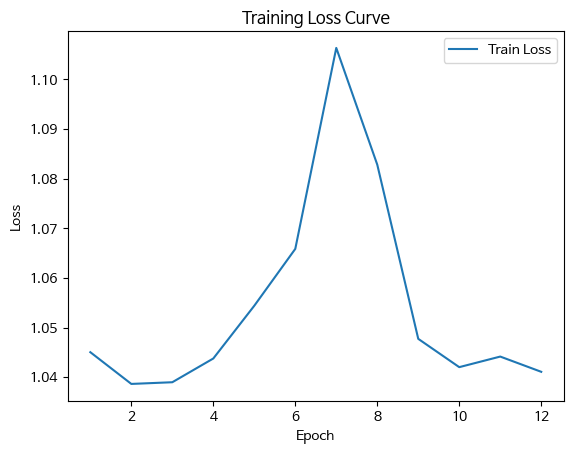

In [55]:
# @title TF Train

gc.collect()
torch.cuda.empty_cache()

# for tqdm
from tqdm import tqdm

# for trainig mode
epoch = 50
tf_model.train()
progress = tqdm(range(epoch))

# for drawing loss per epoch.
max_non_improvement = 10  # 일정 기간동안 개선되지 않을 때 학습을 종료하기 위한 조건
best_loss = float('inf')  # 최적의 손실 값을 추적하기 위한 변수
no_improvement_count = 0  # 개선되지 않은 에포크 카운트

for i in progress:
  batchloss = 0.0
  for (inputs, outputs) in train_loader:
    # inputs.shape: [batch_size, iw, 1] -> 1 말구 num_of features
    # outputs.shape: [batch_size, ow, 1]
    # Initialize grad
    optimizer.zero_grad()                                           # zero_grad()로 Torch.Tensor.grad 초기화. 초기화하지 않으면 다음 루프 backward() 시에 간섭함.
    # 모델에 사용할 마스크 생성
    # Forward propagation with masking
    src_mask = tf_model.generate_square_subsequent_mask(inputs.shape[1]).to(device)

    result = tf_model(inputs.float().to(device), src_mask)             # forward

    # Backward propagation
    loss = criterion(result, outputs[:,:,0].float().to(device))     # ?? 64개 중 하나만 loss를 담네?
    # print(f"[result]\n{result}\n\n[output[:,:,0]]\n{outputs[:,:,0]}\n\n[outputs]\n{outputs}")
    loss.backward()                                                 # backward
    optimizer.step()
    batchloss += loss

  print()
  progress.set_description(f"loss: {batchloss.cpu().item() / len(train_loader):0.6f}")

  # 훈련 손실 값 저장
  train_losses.append(batchloss.cpu().item() / len(train_loader))

  # 조기 종료 검사 및 학습 곡선 그리기
  if batchloss < best_loss:
    best_loss = batchloss
    no_improvement_count = 0
  else:
    no_improvement_count += 1

  if no_improvement_count >= max_non_improvement:
    print(f"Early stopping due to no improvement for {max_non_improvement} epochs.")
    break

progress.close()

# 학습 곡선 그리기
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

## 3) TF Test

In [86]:
# set evaluation mode
tf_model.eval()

# Initialize correct & total
correct = 0
total = 0

my_array = np.array([])

# 기울기 계산을 방지하기 위해 torch.no_grad() 블록 안에서 평가
with torch.no_grad():
  for (inputs, outputs) in tqdm(test_loader, desc="Evaluating"):
    # Forward propagation with masking
    src_mask = tf_model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
    result = tf_model(inputs.float().to(device), src_mask)

    # 상승/하강 예측
    predicted_changes = torch.sign(result[:, -1] - inputs[:, -1, 0].to(device))             # 마지막 예측 값 - 마지막 입력 값
    true_changes = torch.sign(outputs[:, -1, 0].to(device) - inputs[:, -1, 0].to(device))  # 실제 마지막 값 - 마지막 입력 값

    # 예측이 맞는 경우
    correct += (predicted_changes == true_changes).sum().item()
    total += inputs.size(0)

  progress.set_description(f"current accuracy: {correct/total:0.6f}")

# 정확도 계산
accuracy = correct / total
print(f"\nTF model) Directional Accuracy: {accuracy * 100:.6f}%")


Evaluating: 100%|██████████| 26/26 [00:00<00:00, 124.90it/s]


TF model) Directional Accuracy: 60.097919%


# **lstm**

In [63]:
# #이 함수 필요없음

# def reshape_function(lstm_X): #lstm 모델을 위한 데이터 reshape함수.
#   # 3차원 배열을 2차원으로 변환
#   lstm_X_reshaped = lstm_X.reshape(-1, lstm_X.shape[-1])

#   # MinMaxScaler 객체 생성
#   scaler = MinMaxScaler()

#   # 스케일링을 위해 데이터에 적합(fit)하고 변환(transform)
#   scaled_data = scaler.fit_transform(lstm_X_reshaped)

#   # 다시 3차원 형태로 변환
#   lstm_X = scaled_data.reshape(lstm_X.shape)

#   return lstm_X

In [129]:

def lstm_fit(): # lstm 데이터 생성 및 모델 구성, 학습하는 함수.

  # 데이터 시퀀스
  sequence_length = 14

  lstm_X = []
  lstm_y = []
  lstm_test_X = []
  lstm_test_y = []

  for i in range(len(train_X) - sequence_length - 1):
      lstm_X.append(train_X[i:i+sequence_length])
      lstm_y.append([train_y[i+sequence_length]])

  for i in range(len(test_X) - sequence_length - 1):
      lstm_test_X.append(test_X[i:i+sequence_length])
      lstm_test_y.append([test_y[i+sequence_length]])

  lstm_X = np.array(lstm_X)
  lstm_y = np.array(lstm_y)
  lstm_test_X = np.array(lstm_test_X)
  lstm_test_y = np.array(lstm_test_y)

  # LSTM 모델 구성
  lstm_model = Sequential()
  lstm_model.add(LSTM(50, input_shape=(lstm_X.shape[1], lstm_X.shape[2]))) # 21,3
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mean_squared_error')

  # 모델 학습
  lstm_model.fit(lstm_X, lstm_y, epochs=100, batch_size=32)

  # 모델 실행
  loss = lstm_model.evaluate(lstm_test_X, lstm_test_y)
  print(f'Test Loss: {loss}')

  return lstm_model, lstm_test_X, lstm_test_y

## **SVM**

svm 모델 생성하고 학습하는 함수


linear kernel을 사용할 때 정확도가 소폭 상승함.

*   항목 추가
*   항목 추가



**분류 문제를 위한 상승, 하락 이진분류 라벨을 담은 배열을 만들어주는 함수.**

In [122]:
def svm_binary_classify(train_data_y):
  # 전일 대비 상승(1) 또는 하락(0) 여부를 담을 배열 초기화
  price_movement = np.zeros(len(train_data_y), dtype=int)

  # 주가 데이터를 기반으로 전일 대비 상승 또는 하락 여부를 계산
  for i in range(1, len(train_data_y)):
      if train_data_y[i] > train_data_y[i - 1]:
          price_movement[i] = 1  # 상승
      elif train_data_y[i] < train_data_y[i - 1]:
          price_movement[i] = 0  # 하락

  return price_movement

In [109]:
def svm_fit():
  train_y_binary = svm_binary_classify(train_y)
  test_y_binary = svm_binary_classify(test_y)

  #  SVM 모델 생성 및 학습
  svm_model = SVC(kernel='linear', C=1)
  svm_model.fit(train_X, train_y_binary)

  return svm_model, test_y_binary


In [75]:
# def svm_fit():

#   # SVR 모델 생성하여 학습함.
#   svm_model = SVR(kernel='linear')  # Radial basis function (RBF) 커널 사용 <->linear regression도 있다.

#   # 모델 학습
#   svm_model.fit(train_X[:-1], train_y[1:])

#   return svm_model

## **LSTM, SVM 예측 및 정확도 측정**

**lstm 정확도 측정 함수**

In [81]:
def calculate_accuracy(predicted_prices, actual_prices):
    if len(actual_prices) != len(predicted_prices):
        print(len(actual_prices),len(predicted_prices))
        raise ValueError("데이터의 길이가 일치해야 합니다.")

    correct_predictions = 0

    for i in range(len(actual_prices) - 1):
        if (predicted_prices[i+1] - actual_prices[i]) * (actual_prices[i+1] - actual_prices[i]) >= 0:
            correct_predictions += 1

    accuracy = (correct_predictions / (len(actual_prices) - 1)) * 100  # 정확도 계산 (마지막 데이터는 다음 데이터가 없어서 제외)

    return accuracy

**LSTM**

Epoch 1/100
60/60 [==============================] - 2s 4ms/step - loss: 0.2059
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0187
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 8/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 9/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 13/100
60/60 [=================

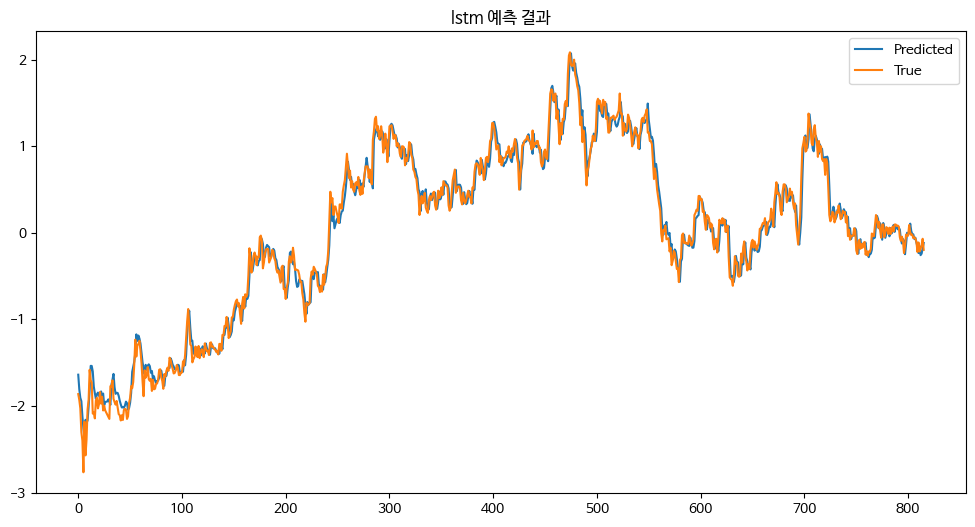

In [130]:
# 하위 모델 생성
lstm_model, lstm_test_X, lstm_test_y =  lstm_fit()  # LSTM 모델을 구성하고 학습한 모델

# 하위 모델 예측
lstm_predictions = lstm_model.predict(lstm_test_X)
lstm_predictions = lstm_predictions.reshape(lstm_predictions.shape[0])
lstm_test_y = lstm_test_y.reshape(lstm_test_y.shape[0])


# lstm 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(lstm_predictions, label='Predicted')
plt.plot(lstm_test_y, label='True')
plt.title('lstm 예측 결과')
plt.legend()
plt.show()


**SVM**

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 하위 모델 생성
svm_model, test_y_binary = svm_fit()

# 모델 예측
svm_predictions = svm_model.predict(test_X)

# 정확도 평가
svm_accuracy = accuracy_score(test_y_binary, svm_predictions)
svm_accuracy = svm_accuracy * 100
print(f'svm 정확도 : {svm_accuracy:.6f}%')

# 예측 결과 시각화
# plt.figure(figsize=(12, 6))
# plt.scatter(test_y_binary, svm_predictions)
# # plt.plot(x = test_y_binary, y=svm_predictions,kind='scatter')

# # plt.plot(test_y_binary, label='True')
# # plt.plot(svm_predictions, label='Predicted')
# plt.title('svm 주가 예측 결과')
# plt.legend()
# plt.show()


svm 정확도 : 58.139535%


svr -> regression model (분류모델(svc)보다 정확도가 낮아 svc방식 선택)

In [ ]:
# # 모델 생성
# svm_model = svm_fit()

# # 모델 예측
# svm_predictions = svm_model.predict(test_X[:-1])

# # 성능 평가 (평균 제곱 오차)
# mse = mean_squared_error(test_y[1:], svm_predictions)
# print(f'svm loss (MSE): {mse}')

# # 예측 결과 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(test_y, label='True')
# plt.plot(svm_predictions, label='Predicted')
# plt.title('svm 주가 예측 결과')
# plt.legend()
# plt.show()

In [131]:

lstm_accuracy=calculate_accuracy(lstm_predictions, lstm_test_y)

print(f"lstm 정확도: {lstm_accuracy:.6f}%")
print(f"svm 정확도: {svm_accuracy:.6f}%")


lstm 정확도: 56.319018%
svm 정확도: 58.139535%
